In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StringType
import pyspark.sql.functions as F 
import pandas as pd
import seaborn as sns
import time
from typing import List
import re
import matplotlib.pyplot as plt

In [2]:
def build_session(cores: int, max_cores: int):
    ss = SparkSession.builder\
    .master("spark://192.168.2.166:7077")\
    .config("spark.executor.cores",cores)\
    .config("spark.cores.max", max_cores)\
    .config("spark.executor.memory", "1300m")\
    .appName("8882_max")\
    .getOrCreate()
    return ss

In [3]:
profanity_dict={
    "sexual_orientation" : [
        "fag",
        "faggot",
        "dyke",
        "cocksucker"
    ],
    "disability" : [
        "retard",
        "retarded",
        "idiot",
        "moron",
        "dumbass",
        "stupid",
        "dumbfuck"
    ],
    "gender" : [
        "cunt",
        "twat",
        "bitch",
        "pussy",
        "dick",
        "cock",
        "whore",
        "moid",
        "femoid"
    ],
    "ethnicity" : [
        "nigger",
        "nigga",
        "wigger",
        "whigger",
        "sandnigger",
        "chink",
        "spic"
    ]}

In [4]:
reverse_profanity_dict = {word:category for (category, words) in profanity_dict.items() for word in words}

In [5]:
alt_subreddits = [
    "The_Donald",
    "politics",
    "news",
    "conspiracy",
    "Uncensored",
    "Health",
    "PoliticsAll",
    "Conservative",
    "worldnews",
    "WhiteRights",
    "KotakuInAction",
    "HillaryForPrison",
    "TheOnion",
    "AskTrumpSupporters",
    "POLITIC",
    "rss_theonion",
    "the_Europe",
    "new_right",
    "AskReddit",
    "AnythingGoesNews"]

main_subreddits = [
    "politics",
    "worldnews",
    "The_Donald",
    "news",
    "TheColorIsBlue",
    "TheColorIsRed",
    "willis7737_news",
    "news_etc",
    "AskReddit",
    "canada",
    "EnoughTrumpSpam",
    "NoFilterNews",
    "BreakingNews24hr",
    "conspiracy",
    "todayilearned",
    "thenewsrightnow",
    "europe",
    "ReddLineNews",
    "hillaryclinton",
    "nottheonion"]

combined_subs = list(set(main_subreddits).union(set(alt_subreddits)))

In [6]:
def read_files(session, paths):
    return session.read.format('json').load(paths)

In [7]:
def filter_subreddits(df, subreddits):
    return df[['body', 'subreddit', "id"]].filter(df.subreddit.isin(subreddits))

In [8]:
#Check total number of posts in each subreddit
def calc_total_posts_for_subreddits(df):
    return df2.groupBy("subreddit").count().sort("count", ascending=False)

In [9]:
#Reduce the body to only contain profanities, then "explode" each word to a new row
def split_words_to_new_rows(df):
    ##Clean the words and filter them out. All words not in the list is removed, and "!ret12arded." = "retarded"
    #def clean_word(words: List) -> List:
    #    cleaned_words = []
    #    for word in words:
    #        word = ''.join(e.lower() for e in word if e.isalpha())
    #        if reverse_profanity_dict.get(word, None):
    #            cleaned_words.append(word)
    #    return cleaned_words
    
    
    def clean_word(text):
        pattern = re.compile('[^a-zA-Z]+')
        cleaned_words = []
        for word in pattern.sub(' ', text).lower().split():
            if word in reverse_profanity_dict:
                cleaned_words.append(word)
        return cleaned_words
    
    udf_clean_word = F.udf(clean_word, ArrayType(StringType()))
    
    return df.withColumn('word', F.explode(udf_clean_word(df['body']))).select(["subreddit", "word","id"])

In [10]:
#Total number of use for each profanity within each subreddit
#df4 = df3.groupBy(["subreddit", "word"]).count().sort("count", ascending=False).cache()
#df4.show(n=200)

In [11]:
#Number of WORDS from each category, grouped by subreddit
'''df5 = df4.withColumn("category", udf_word_to_category(df3["word"])).select(["subreddit", "category", "count"])
df6 = df5.groupBy(["subreddit", "category"]).agg(F.sum("count").alias("count")).sort(["subreddit", "count"])
df6.count()'''

'df5 = df4.withColumn("category", udf_word_to_category(df3["word"])).select(["subreddit", "category", "count"])\ndf6 = df5.groupBy(["subreddit", "category"]).agg(F.sum("count").alias("count")).sort(["subreddit", "count"])\ndf6.count()'

In [12]:
#Number of INDIVIDUAL POSTS containing profanity (by category), grouped by subreddit. 
#One post can count to many categories, but only once per category
def calc_individual_posts_containing_profanities(df):
    def word_to_category(w: str) -> str:
        return reverse_profanity_dict[w]

    udf_word_to_category = F.udf(word_to_category, StringType())
    df2 = df.withColumn("category", udf_word_to_category(df["word"])).select(["subreddit", "category", "id"]).dropDuplicates(["id", "category"])
    
    return df2.groupBy(["subreddit", "category"])\
        .count()\
        .sort(["subreddit", "count"])

In [13]:
#Strong scaling
num_of_cores = [2, 4, 8]
results_strong = []

for cores in num_of_cores:
    #Build Session
    ss = build_session(1, cores)
    #read files
    print("Reading files...")
    read_start = time.time()
    df = read_files(ss, 'hdfs://master:9000/experiment/RC_2011-08.bz2')
    read_time = time.time() - read_start
    print("Files read!")
    
    start_time = time.time()
    
    #filter on subreddits
    print("Filtering subreddits...")
    df2 = filter_subreddits(df,combined_subs).cache()
    
    print("Calculating number of posts in each subreddit...")
    #Calc total number of posts in each subreddit
    df_total_posts = calc_total_posts_for_subreddits(df2)
    
    print("Exploding profanities to separate rows...")
    #explode all profanities to separate rows
    df3 = split_words_to_new_rows(df2)
    
    print("Calculate frequency of profanity categories...")
    #Number of INDIVIDUAL POSTS containing profanity (by category), grouped by subreddit. 
    #One post can count to many categories, but only once per category
    df4 = calc_individual_posts_containing_profanities(df3)
    
    print("Collecting...")
    df4.collect()
    #pd_df4 = df4.toPandas()
    #pd_tot = df_total_posts.toPandas()
    #pd_merged = pd_df4.merge(pd_tot, on="subreddit")
    #pd_merged["freq"] = pd_merged["count_x"]/pd_merged["count_y"]
    #sns.catplot(x = "category",       # x variable name
    #        y = "freq",       # y variable name
    #        hue = "subreddit",  # elements in each group variable name
    #        data = pd_merged,     # dataframe to plot
    #        kind = "bar")
    execution_time = time.time() - start_time
    print(f"Execution time: {execution_time}s")
    results_strong.append((cores, execution_time, read_time, execution_time + read_time ))
    ss.stop()
df_results_strong = pd.DataFrame(data=results_strong, columns=["cores", "execution_time (s)", "read_time (s)", "total_time (s)"])
print("-------------------")
df_results_strong

Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...
Execution time: 254.2949788570404s
Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...
Execution time: 137.9347791671753s
Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...
Execution time: 84.58886122703552s
-------------------


,cores,execution_time (s),read_time (s),total_time (s)
0,2,254.294979,495.224359,749.519338
1,4,137.934779,254.858291,392.793071
2,8,84.588861,150.308978,234.897840


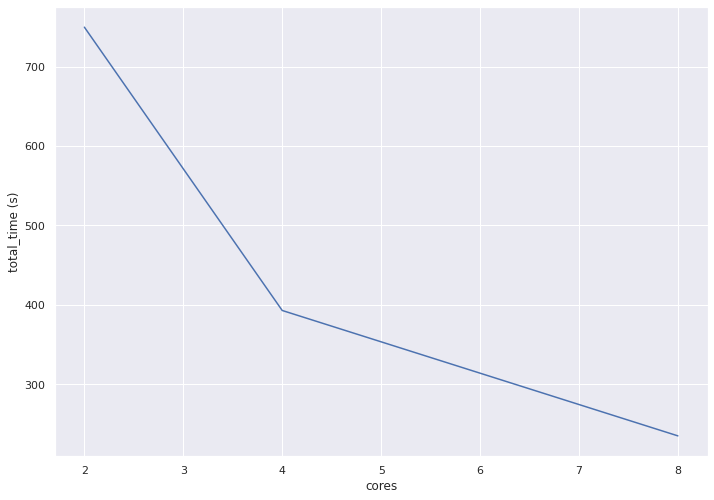

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="cores", y="total_time (s)", data=df_results_strong)

In [15]:
#Weak Scaling
num_of_cores = [2, 4, 8]
files= ['hdfs://master:9000/experiment/RC_2011-08.bz2', 
        'hdfs://master:9000/experiment/RC_2011-09.bz2', 
        'hdfs://master:9000/experiment/RC_2012-09.bz2']
results_weak = []

for index, cores in enumerate(num_of_cores):
    #Build Session
    ss = build_session(1, cores)
    #read files
    print("Reading files...")
    read_start = time.time()
    df = read_files(ss, files[0 : (index+1) ])
    read_time = time.time() - read_start
    print("Files read!")
    
    
    start_time = time.time()
    
    #filter on subreddits
    print("Filtering subreddits...")
    df2 = filter_subreddits(df,combined_subs).cache()
    
    print("Calculating number of posts in each subreddit...")
    #Calc total number of posts in each subreddit
    df_total_posts = calc_total_posts_for_subreddits(df2)
    
    print("Exploding profanities to separate rows...")
    #explode all profanities to separate rows
    df3 = split_words_to_new_rows(df2)
    
    print("Calculate frequency of profanity categories...")
    #Number of INDIVIDUAL POSTS containing profanity (by category), grouped by subreddit. 
    #One post can count to many categories, but only once per category
    df4 = calc_individual_posts_containing_profanities(df3)
    
    print("Collecting...")
    df4.collect()
    #pd_df4 = df4.toPandas()
    #pd_tot = df_total_posts.toPandas()
    #pd_merged = pd_df4.merge(pd_tot, on="subreddit")
    #pd_merged["freq"] = pd_merged["count_x"]/pd_merged["count_y"]
    #sns.catplot(x = "category",       # x variable name
    #        y = "freq",       # y variable name
    #        hue = "subreddit",  # elements in each group variable name
    #        data = pd_merged,     # dataframe to plot
    #        kind = "bar")
    execution_time = time.time() - start_time
    print(f"Execution time: {execution_time}s")
    results_weak.append((cores, index+1, execution_time, read_time, execution_time + read_time ))
    ss.stop()
df_results_weak = pd.DataFrame(data=results_weak, columns=["cores", "num_of_files (~1GB)", "execution_time (s)", "read_time (s)", "total_time (s)"])
print("-------------------")
df_results_weak

Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...
Execution time: 257.610298871994s
Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...
Execution time: 259.9043126106262s
Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...
Execution time: 278.23817205429077s
-------------------


,cores,num_of_files (~1GB),execution_time (s),read_time (s),total_time (s)
0,2,1,257.610299,245.734397,503.344696
1,4,2,259.904313,249.864041,509.768353
2,8,3,278.238172,260.897707,539.135879


AttributeError: 'AxesSubplot' object has no attribute 'ylim'

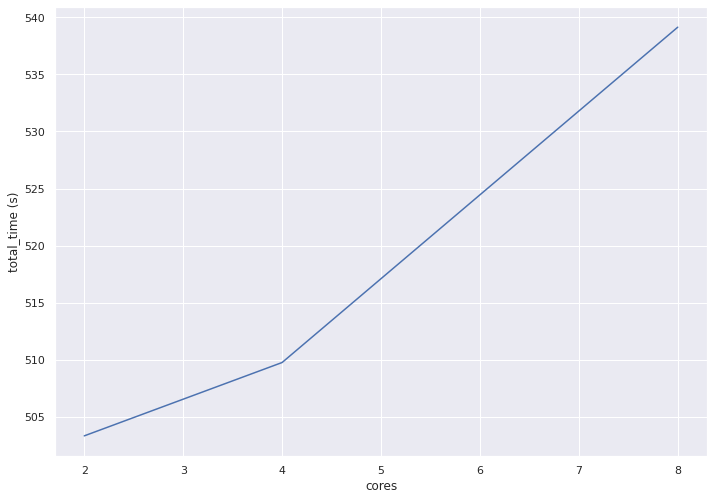

In [22]:
sns.lineplot(x="cores", y="total_time (s)", data=df_results_weak).ylim(0, 540)

In [17]:
#Analysis w/ bar plot

files= 'hdfs://master:9000/experiment/*.bz2'

#Build Session
ss = build_session(1, 8)
#read files
print("Reading files...")
read_start = time.time()
df = read_files(ss, files)
print("Files read!")

#filter on subreddits
print("Filtering subreddits...")
df2 = filter_subreddits(df,combined_subs).cache()

print("Calculating number of posts in each subreddit...")
#Calc total number of posts in each subreddit
df_total_posts = calc_total_posts_for_subreddits(df2)

print("Exploding profanities to separate rows...")
#explode all profanities to separate rows
df3 = split_words_to_new_rows(df2)

print("Calculate frequency of profanity categories...")
#Number of INDIVIDUAL POSTS containing profanity (by category), grouped by subreddit. 
#One post can count to many categories, but only once per category
df4 = calc_individual_posts_containing_profanities(df3)

print("Collecting...")
pd_df4 = df4.toPandas()
pd_tot = df_total_posts.toPandas()
pd_merged = pd_df4.merge(pd_tot, on="subreddit")
pd_merged["freq"] = pd_merged["count_x"]/pd_merged["count_y"]


Reading files...
Files read!
Filtering subreddits...
Calculating number of posts in each subreddit...
Exploding profanities to separate rows...
Calculate frequency of profanity categories...
Collecting...


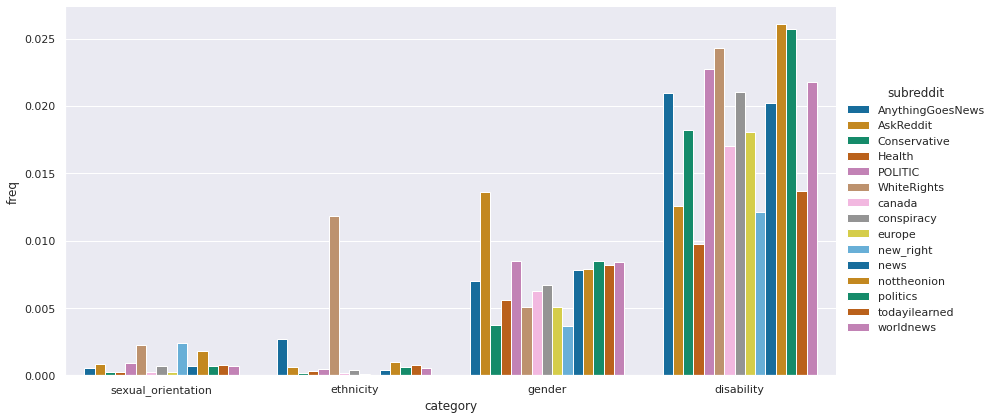

In [18]:
sns.catplot(
        x = "category",       # x variable name
        y = "freq",       # y variable name
        hue = "subreddit",  # elements in each group variable name
        data = pd_merged,     # dataframe to plot
        kind = "bar",
        palette = "colorblind",
        height = 6,
        aspect = 2)

In [19]:
ss.stop()